In [185]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from utils import get_backend_properties_v1

# from blackwater.data.utils import (
#     generate_random_pauli_sum_op,
#     create_estimator_meas_data,
#     circuit_to_graph_data_json,
#     get_backend_properties_v1,
#     encode_pauli_sum_op,
#     create_meas_data_from_estimators
# )

from mlp import MLP1, MLP2, MLP3, encode_data

#from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise, RemoveReadoutErrors
from mlp import recursive_dict_loop, count_gates_by_rotation_angle
from mbd_utils import calc_imbalance
import torch
from torch import nn
from sklearn import datasets
import sklearn
from utils import circuit_to_graph_data_json
from utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
)
from qiskit.circuit.random import random_circuit
from sklearn.model_selection import train_test_split

In [186]:
def remove_str_in_data(data):
    return [item for item in data if not isinstance(item, str)]

In [187]:
def unpack_data(data):
    flattened_list = []
    for node_type, node_data in data['nodes'].items():
        for sublist in node_data:
            flattened_list.extend(sublist)
    for node_type, node_data in data['edges'].items():
        for sublist in node_data:
            flattened_list.extend(sublist)
    return flattened_list

In [188]:
backend = FakeLima()

In [189]:
def create_train_and_test_data(n_qubits: int, 
                               circuit_depth: int, 
                               pauli_terms: int, 
                               pauli_coeff: float = 1.0, 
                               max_entries: int = 10, 
                               properties = get_backend_properties_v1(backend)):
    
    circuits_list = []
    ideal_exp_vals_list = []
    noisy_exp_vals_list = []

    for _ in range(max_entries):
        qc = random_circuit(n_qubits, random.randint(1, circuit_depth))

        observable = generate_random_pauli_sum_op(n_qubits, pauli_terms, pauli_coeff)

        ideal_exp_val, noisy_exp_val = create_estimator_meas_data(
            backend=backend, circuit=qc, observable=observable
        )

        circuits_list.append(qc)
        ideal_exp_vals_list.append(ideal_exp_val)
        noisy_exp_vals_list.append(noisy_exp_val)

    return circuits_list, ideal_exp_vals_list, noisy_exp_vals_list


In [190]:
train_circuits, train_ideal_exp_val, train_noisy_exp_val = create_train_and_test_data(2, 2, 1, 1, 400)
test_circuits, test_ideal_exp_val, test_noisy_exp_val = create_train_and_test_data(2, 2, 1, 1, 100)

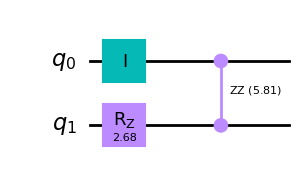

In [191]:
train_circuits[2].draw('mpl')

In [192]:
def encode_data_circuit(circuits, ideal_exp_vals, noisy_exp_vals, backend):
    features = []
    
    for qc in circuits:
        single_qc_features = []

        qc_transpiled = transpile(qc, backend, optimization_level=0)

        graph_data = circuit_to_graph_data_json(
            circuit=qc_transpiled,
            properties=get_backend_properties_v1(backend),
            use_qubit_features=True,
            use_gate_features=True,
        )
        resulting_graph_features = remove_str_in_data(unpack_data(graph_data))

        for item in resulting_graph_features: single_qc_features.append(float(item))

        features.append(single_qc_features)

    # this is inefficient

    max = 10000
    for i in range(len(features)):
        if max < len(features[i]):
            max = len(features[i])

    i = 0

    for item in features:
        while len(item) < max:
            item.append(0)
        item.append(noisy_exp_vals[i])
        i += 1

    X = torch.Tensor(features)

    y = []

    for ideal_exp_val in ideal_exp_vals: y.append(ideal_exp_val)

    y = torch.Tensor(y)
    
    return X, y

In [193]:
X_train, y_train = encode_data_circuit(train_circuits, train_ideal_exp_val, train_noisy_exp_val, backend)
X_test, y_test = encode_data_circuit(test_circuits, test_ideal_exp_val, test_noisy_exp_val, backend)
#X_test, y_test = encode_data_circuit(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals_input)

In [194]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [195]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [196]:
y_pred_rf = rfr.predict(X_test)
rms = root_mean_squared_error(y_test, y_pred_rf)

In [197]:
print(rms)

0.05446335562498234


In [198]:
from mlp import encode_data

In [199]:
X_train_2, y_train_2 = encode_data(train_circuits, properties=get_backend_properties_v1(backend), ideal_exp_vals=train_ideal_exp_val, noisy_exp_vals=train_noisy_exp_val, num_qubits=1)
X_test_2, y_test_2 = encode_data(test_circuits, properties=get_backend_properties_v1(backend), ideal_exp_vals=test_ideal_exp_val, noisy_exp_vals=test_noisy_exp_val, num_qubits=1)

In [200]:
#X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, shuffle=True)
rfr_2 = RandomForestRegressor(n_estimators=10)
rfr_2.fit(X_train_2, y_train_2)
y_pred_rf_2 = rfr_2.predict(X_test_2)
rms_2 = root_mean_squared_error(y_test_2, y_pred_rf_2)
print(rms_2)

0.04879382259341668


In [201]:
qc = train_circuits[0]
qc_graph =  circuit_to_graph_data_json(
            circuit=transpile(qc, backend, optimization_level=0),
            properties=get_backend_properties_v1(backend),
            use_qubit_features=True,
            use_gate_features=True,
        )

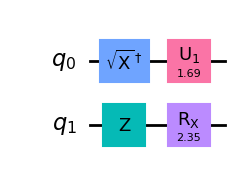

In [202]:
qc.draw('mpl')

In [203]:
qc_graph

{'nodes': {'DAGOpNode': [[1.5707963267948966,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    5.9698643286635694e-05,
    0.0,
    0.0,
    9.355584184359312e-05,
    0.0,
    0.0,
    0.026100000000000012,
    0.0,
    0.0,
    0,
    0],
   [1.5707963267948966,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    5.9698643286635694e-05,
    0.0,
    0.0,
    9.355584184359312e-05,
    0.0,
    0.0,
    0.026100000000000012,
    0.0,
    0.0,
    0,
    0],
   [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    5.9698643286635694e-05,
    0.0,
    0.0,
    9.355584184359312e-05,
    0.0,
    0.0,
    0.026100000000000012,
    0.0,
    0.0,
    0.00019195510390342677,
    35.55555555555556],
   [1.5707963267948966,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    5.9698643286635694e-05,
    0.0,
    0.0,
    

In [204]:
import json
import torch

In [205]:
# Convert tensor to a nested Python list
#tensor_list = qc_graph.tolist()

# Convert the nested list to JSON
json_data = json.dumps(qc_graph, indent=4)

#print(json_data)

# Specify the file path where you want to save the JSON data
file_path = "graph_circuit_data.json"

# Write the JSON data to the file
with open(file_path, "w") as json_file:
    json_file.write(json_data)

In [206]:
# Convert tensor to a nested Python list
tensor_list = X_train[0].tolist()

# Convert the nested list to JSON
json_data = json.dumps(tensor_list)

# Specify the file path where you want to save the JSON data
file_path = "tensor_data.json"

# Write the JSON data to the file
with open(file_path, "w") as json_file:
    json_file.write(json_data)